## Import data

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict, namedtuple
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

%matplotlib inline

In [2]:
#os.environ["CUDA_VISIBLE_DEVICES"] = '0'

sys.path.append("../dl/models/research/")
sys.path.append("../dl/models/research/object_detection")

In [3]:
from utils import label_map_util
from utils import visualization_utils as vis_util

## Model

In [4]:
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = os.path.join('../dl/models/research/object_detection/data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

### Download Model

In [5]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)

for file in tar_file.getmembers():
    file_name = os.path.basename(file.name)
    if "frozen_inference_graph.pb" in file_name:
        tar_file.extract(file, os.getcwd())

### Load a (frozen) Tensorflow model into memory

In [6]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, "rb") as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name="")

### Loading label map

In [7]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

### Helper code

In [8]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

## Detection

In [9]:
PATH_TO_TEST_IMAGES_DIR = "../dl/VOCdevkit/VOC2012/JPEGImages"
PATH_TO_IMAGE_SETS = "../dl/VOCdevkit/VOC2012/ImageSets/Main/"

train = []
with open(os.path.join(PATH_TO_IMAGE_SETS, "train.txt")) as file:
    train = file.read().splitlines()
    
validate = []
with open(os.path.join(PATH_TO_IMAGE_SETS, "val.txt")) as file:
    validate = file.read().splitlines()
    
TRAIN_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, "{}.jpg".format(image)) for image in train]
VALIDATE_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, "{}.jpg".format(image)) for image in validate]

In [10]:
IMAGE_SIZE = (12, 8)

In [11]:
DetectionResult = namedtuple("DetectionResult", "boxes scores classes")

def detect_objects(files, annotations, visualize=True, metrics={}):
    metrics_values = {name: [] for name in metrics}
    
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            # Definite input and output Tensors for detection_graph
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

            # Each box represents a part of the image where a particular object was detected.
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            
            count = 0
            
            for (image_path, annotation) in zip(files, annotations):
                image = Image.open(image_path)

                # the array based representation of the image will be used later in order to prepare the
                # result image with boxes and labels on it.
                image_np = load_image_into_numpy_array(image)

                # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
                image_np_expanded = np.expand_dims(image_np, axis=0)

                # Actual detection.
                (boxes, scores, classes, num) = sess.run(
                    [detection_boxes, detection_scores, detection_classes, num_detections],
                    feed_dict={image_tensor: image_np_expanded})
                
                result = DetectionResult(boxes.squeeze(), scores.squeeze(), classes.squeeze())
                
                for metric in metrics:
                    metrics_values[metric].append(metrics[metric](annotation, result))
                
                # Visualization of the results of a detection.
                if visualize:
                    vis_util.visualize_boxes_and_labels_on_image_array(
                        image_np,
                        np.squeeze(boxes),
                        np.squeeze(classes).astype(np.int32),
                        np.squeeze(scores),
                        category_index,
                        use_normalized_coordinates=True, line_thickness=8)

                    plt.figure(figsize=IMAGE_SIZE)
                    plt.imshow(image_np)
                    
                count += 1
                
                if count % 100 == 0:
                    print("Processed: {}".format(count))
                
    
    return metrics_values

## Metrics

### Load annotations

In [12]:
import xml.etree.ElementTree as ET

PATH_TO_IMAGE_ANNOTATIONS = "../dl/VOCdevkit/VOC2012/Annotations"
VALIDATE_IMAGE_ANNOTATIONS = [ET.parse(os.path.join(PATH_TO_IMAGE_ANNOTATIONS, "{}.xml".format(image))).getroot() for image in validate]

### Parse annotations

In [13]:
BoundingBox = namedtuple("BoundingBox", "xmin ymin xmax ymax")
Object = namedtuple("Object", "name bndbox")

def get_bndbox(node):
    args = {child.tag: child.text for child in node}
    return BoundingBox(float(args["xmin"]), float(args["ymin"]), float(args["xmax"]), float(args["ymax"]))
    
def get_object(node):
    args = {child.tag: child for child in node}
    return Object(args["name"].text, get_bndbox(args["bndbox"]))
    
def get_objects(node):
    return [get_object(child) for child in node if child.tag == "object"]

### Filter images

In [14]:
category_id = {category["name"]: category["id"] for category in categories}

def is_valid(annotation):
    objects = get_objects(annotation)
    names = np.unique(list(map(lambda it: it.name, objects)))
    
    # no objects
    if len(names) == 0:
        return False
    
    # objects on the image are not unique!
    if len(objects) != len(names):
        return False
    
    # all labels are correct
    return all((name in category_id for name in names))
    
images, annotations = [], []

for (image, annotation) in zip(VALIDATE_IMAGE_PATHS, VALIDATE_IMAGE_ANNOTATIONS):
    if is_valid(annotation):
        images.append(image)
        annotations.append(annotation)

### Limit test data

In [15]:
images = images[:1000]
annotations = annotations[:1000]

### Testing

{}

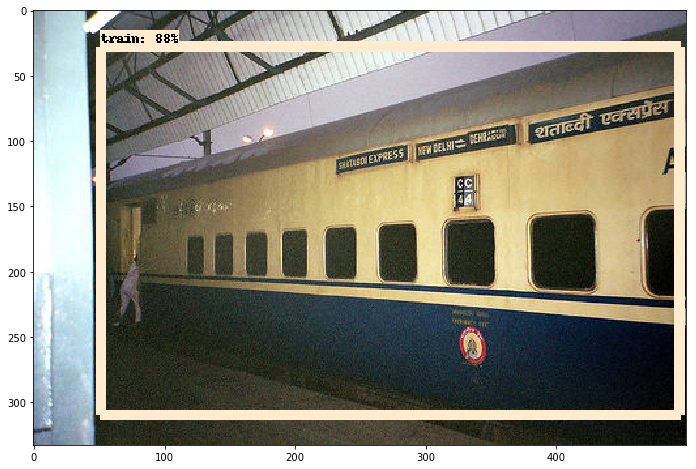

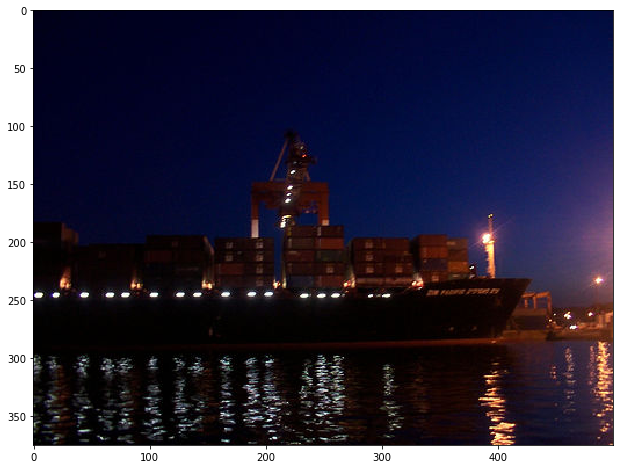

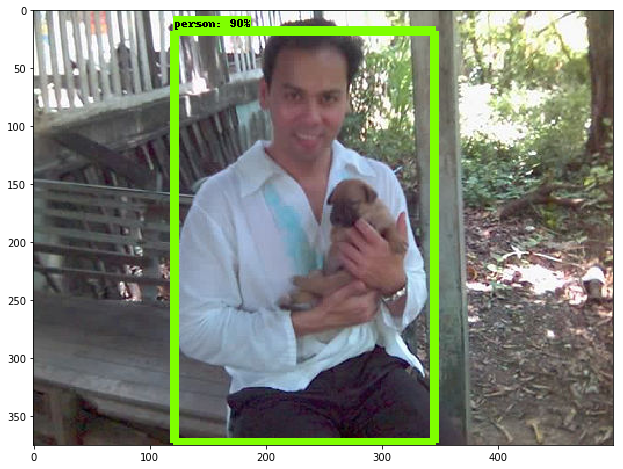

In [16]:
detect_objects(images[:3], annotations[:3])

### Accuracy

In [17]:
def is_detected_acc(obj, result):
    indices = (result.classes == category_id[obj.name])
    return np.max(result.scores[indices]) > 0.5 if np.sum(indices) else 0

def accuracy(annotation, result):
    objects = get_objects(annotation)
    return np.mean([is_detected_acc(obj, result) for obj in objects])

### IoU

In [18]:
def get_intersection(box_1, box_2):
    xmin = max(box_1.xmin, box_2.xmin)
    ymin = max(box_1.ymin, box_2.ymin)
    xmax = min(box_1.xmax, box_2.xmax)
    ymax = min(box_1.ymax, box_2.ymax)
    
    return (xmax - xmin) * (ymax - ymin)

def get_square(box):
    return (box.xmax - box.xmin) * (box.ymax - box.ymin)

def get_iou(box_1, box_2):
    intersection = get_intersection(box_1, box_2)
    union = get_square(box_1) + get_square(box_2) - intersection 
    return intersection / union

def build_bdnbox(args):
    return BoundingBox(375.0 * float(args[0]), 500.0 * float(args[1]), 375 * float(args[2]), 500 * float(args[3]))

In [19]:
def get_max_iou(obj, result):
    indices = (result.classes == category_id[obj.name])
    boxes = (build_bdnbox(box) for box in result.boxes[indices])
    return max(0, np.max([get_iou(box, obj.bndbox) for box in boxes]) if np.sum(indices) else 0)
    
def IoU(annotation, result):
    objects = get_objects(annotation)
    return np.mean([get_max_iou(obj, result) for obj in objects])

### MAP

In [20]:
def is_detected_map(obj, result):
    indices = (result.classes == category_id[obj.name])
    boxes = (build_bdnbox(box) for box in result.boxes[indices])
    
    for box in boxes:
        if get_iou(box, obj.bndbox) > 0.5:
            return 1
        
    return 0
    
def MAP(annotation, result):
    objects = get_objects(annotation)
    return np.mean([is_detected_map(obj, result) for obj in objects])

### Run

In [21]:
metrics = {
    "accuracy": accuracy,
    "IoU": IoU,
    "MAP": MAP
}

values = detect_objects(images, annotations, visualize=False, metrics=metrics)

Processed: 100
Processed: 200
Processed: 300
Processed: 400
Processed: 500
Processed: 600
Processed: 700
Processed: 800
Processed: 900
Processed: 1000


In [22]:
print("Accuracy: {:.2f}%".format(100 * np.mean(values["accuracy"])))
print("Average IoU: {:.2f} px^2".format(np.mean(values["IoU"])))
print("MAP: {:.2f}%".format(100 * np.mean(values["MAP"])))

Accuracy: 76.77%
Average IoU: 4.09 px^2
MAP: 56.77%
